In [12]:
## Summarize deconvolution results

import os
from glob import glob
import pandas as pd
import collections
import numpy as np
import matplotlib.pyplot as plt 
import json
import seaborn as sns
from create_deconv_images import get_combined_data, smooth_timeseries, get_atlas_info

basedir = '/Users/poldrack/data_unsynced/uh2/BIDS_data/derivatives/deconvolution'
figure_dir = os.path.join(basedir, 'figures')
if not os.path.exists(figure_dir):
    os.mkdir(figure_dir)
resultfiles = glob(os.path.join(basedir, 'sub*/func/*_deconvolved.tsv'))
templateflow_home  = os.environ['TEMPLATEFLOW_HOME']


# set the intended values to match on here
spec_dict = {'use_ridge': False,
            'atlas': 'Schaefer2018',
            'use_confounds': True,
            'desc': '400Parcels17Networks',
            }

def spec_dict_to_string(spec_dict):
    spec_string = []
    for k in spec_dict:
        spec_string.append('%s-%s' % (k, spec_dict[k]))
    return('_'.join(spec_string))


spec_string = spec_dict_to_string(spec_dict)



In [2]:
def get_deconv_file_info_from_json(filename):
    with open(filename.replace('.tsv', '.json')) as f:
        info_dict = json.load(f)
    info_dict ['filename'] = filename
    full_split = info_dict['filename'].split('/')
    info_dict['basedir'] = '/'.join(full_split[:-6])
    info_dict['deriv_base'] = '/'.join(full_split[:-5])
    info_dict['desc'] = info_dict['atlas_desc']
    return(info_dict)


def check_spec_match(info_dict, spec_dict):
    spec_match = True
    for key in spec_dict:
        if info_dict[key] != spec_dict[key]:
            #print('mismatch:', info_dict[key], spec_dict[key])
            spec_match = False
    return(spec_match)


datafiles = collections.defaultdict(lambda :[])
info_dict = {}
for filename in resultfiles:
    idict = get_deconv_file_info_from_json(filename)
    if check_spec_match(idict, spec_dict):
        info_dict[filename] = idict
        datafiles[info_dict[filename]['task']].append(filename)
    
    

In [39]:
def summarize_by_yeo_network(df, spec_dict):

    atlas_info = get_atlas_info(spec_dict, os.environ['TEMPLATEFLOW_HOME'])
    df = df.copy()
    df['yeo17'] = [atlas_info.loc[int(i), 'network'] for i in combined_data_long.network]
    networks_df = df.groupby(['time', 'yeo17', 'event_type', 'subcode', 'task']).median().reset_index()
    
    return(networks_df)

In [40]:
combined_data_long = get_combined_data(datafiles, info_dict, spec_dict)

found 97 datasets for task discountFix
found 100 datasets for task stroop
found 100 datasets for task DPX
found 101 datasets for task ANT
found 104 datasets for task WATT3
found 104 datasets for task twoByTwo
found 103 datasets for task stopSignal
found 102 datasets for task CCTHot
found 100 datasets for task motorSelectiveStop


In [41]:
yeo_network_summary = summarize_by_yeo_network(combined_data_long, spec_dict)


plotting discountFix
plotting stroop
plotting DPX
plotting ANT
plotting WATT3
plotting twoByTwo
plotting stopSignal
plotting CCTHot
plotting motorSelectiveStop


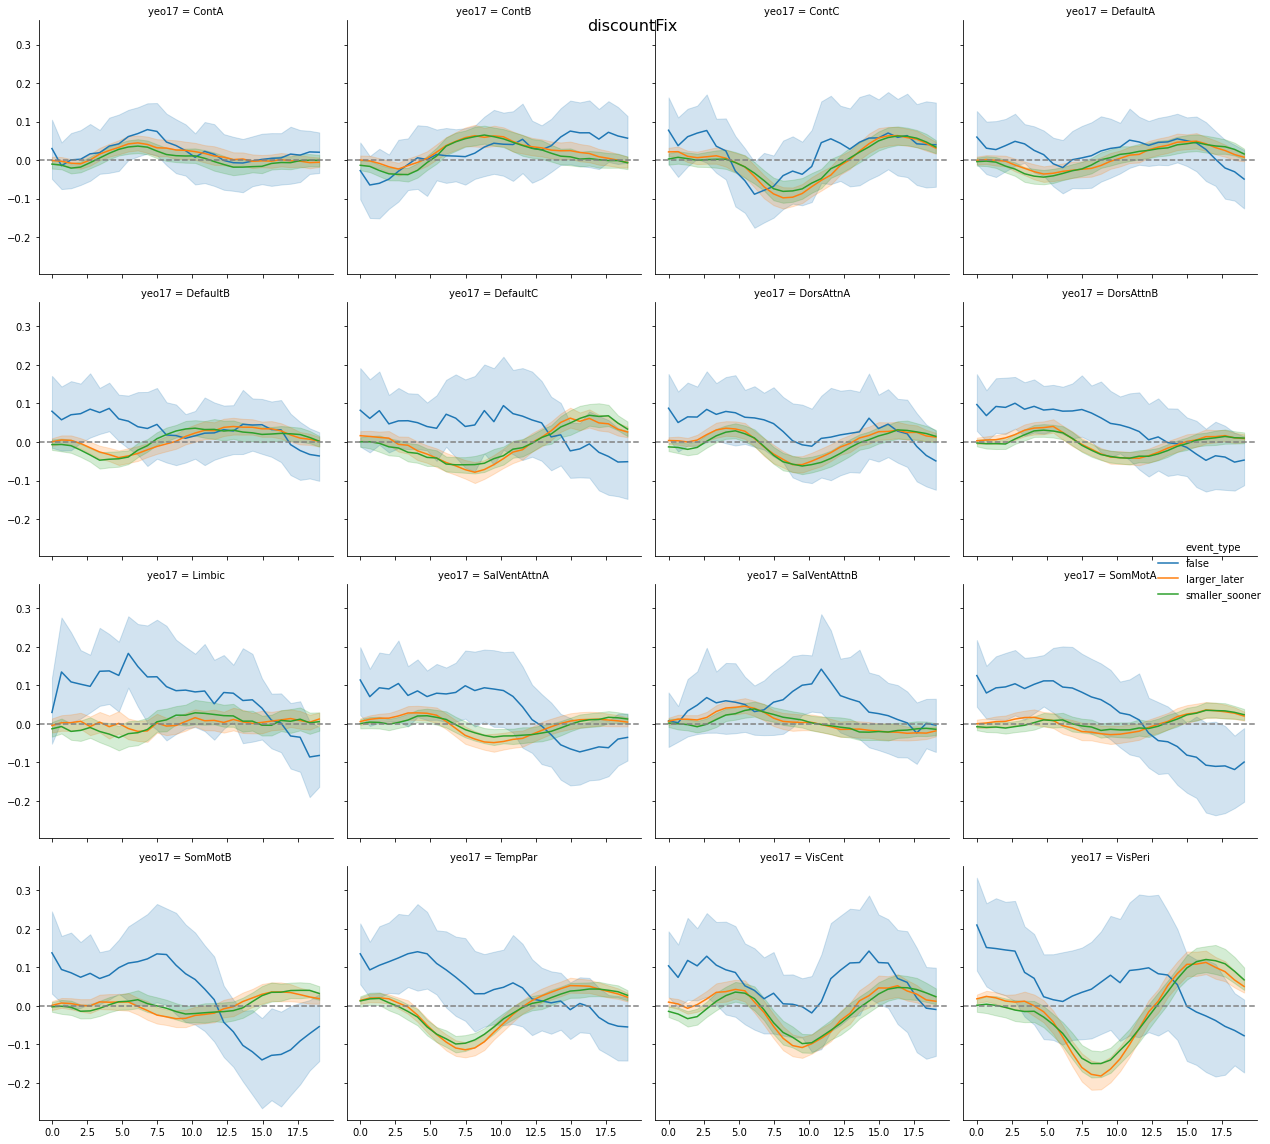

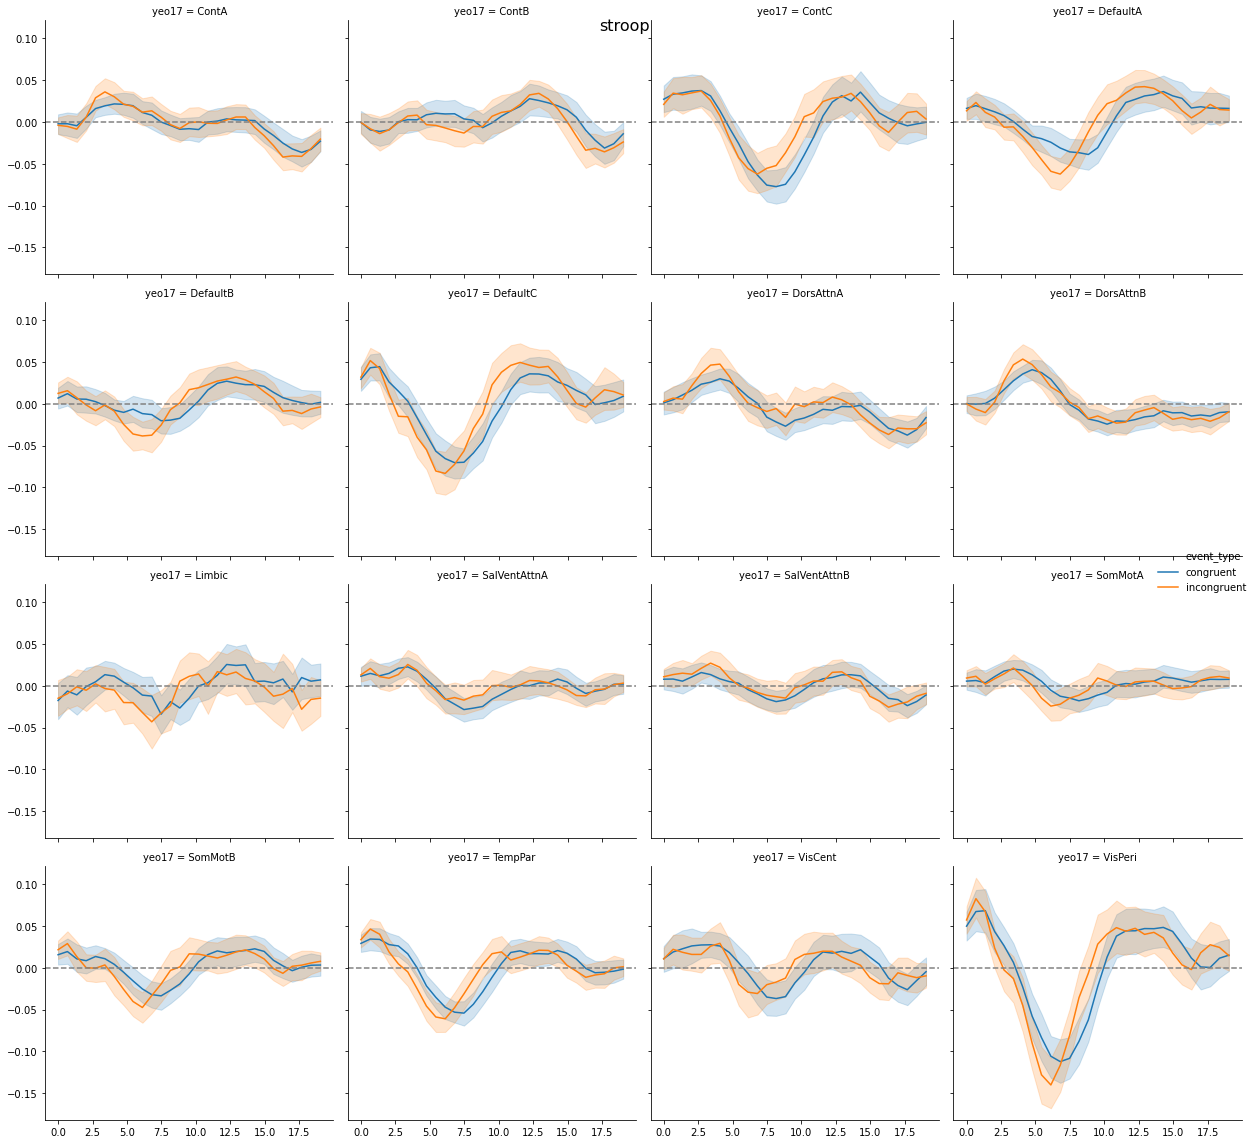

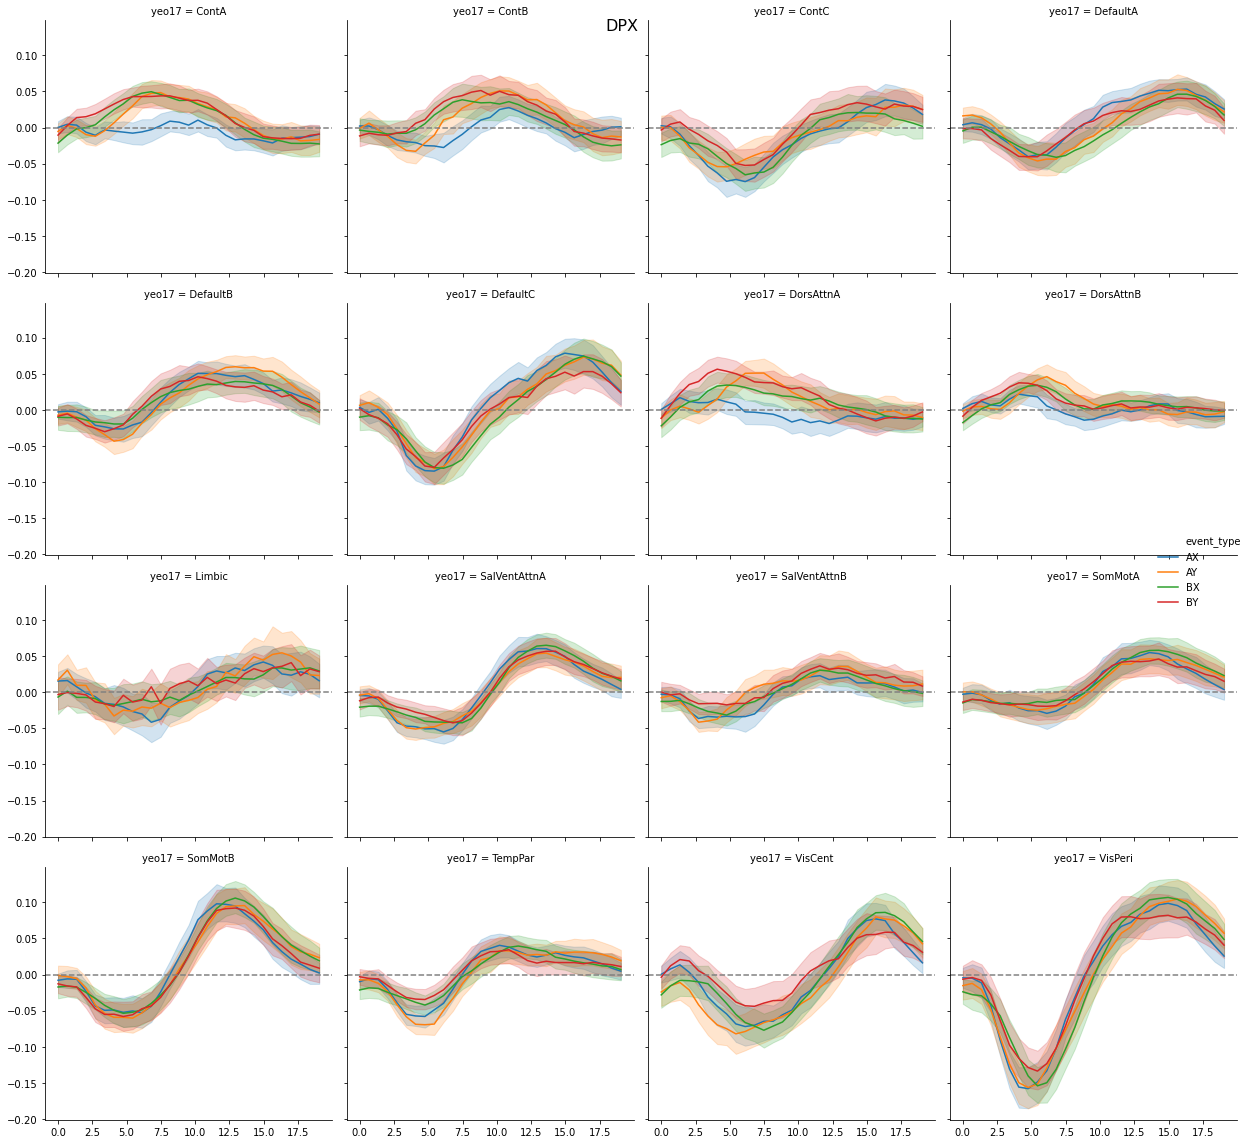

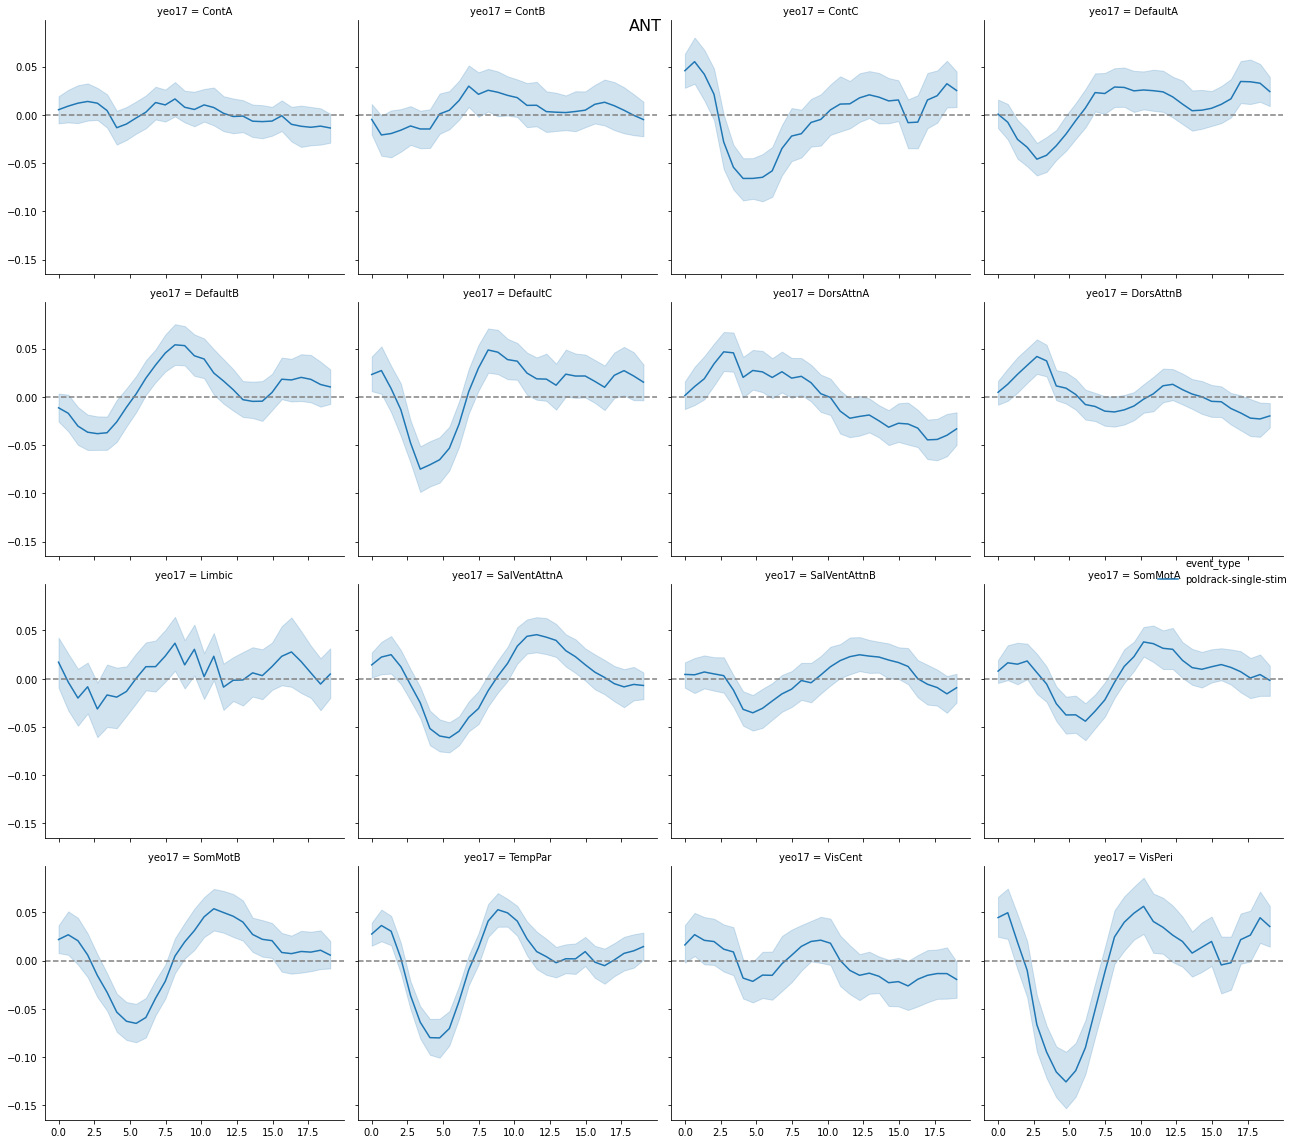

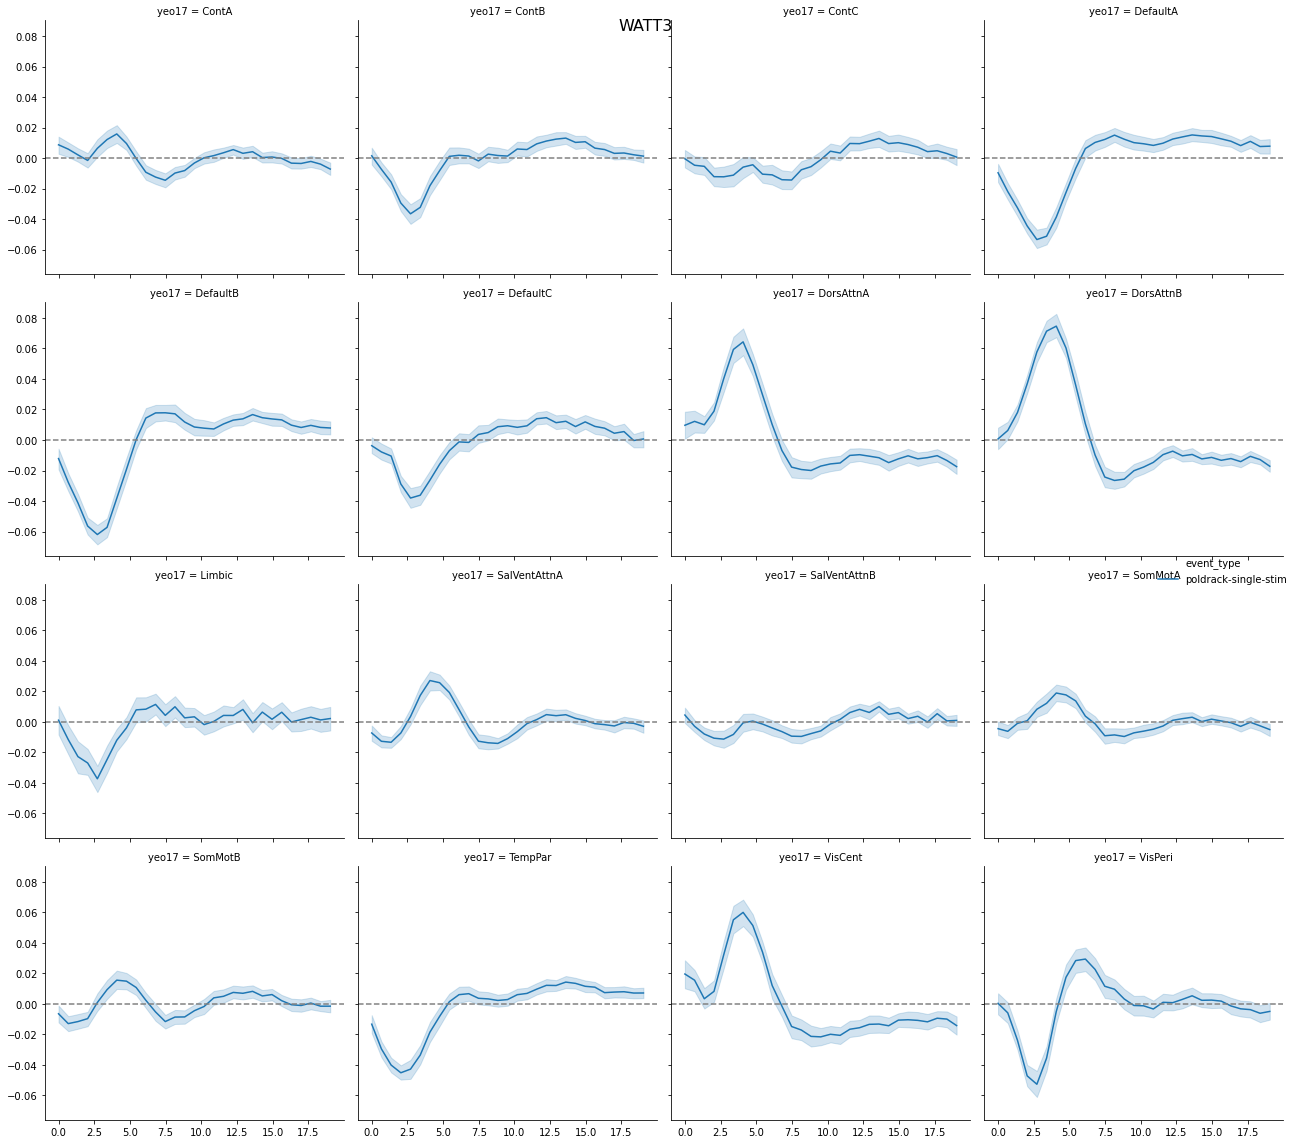

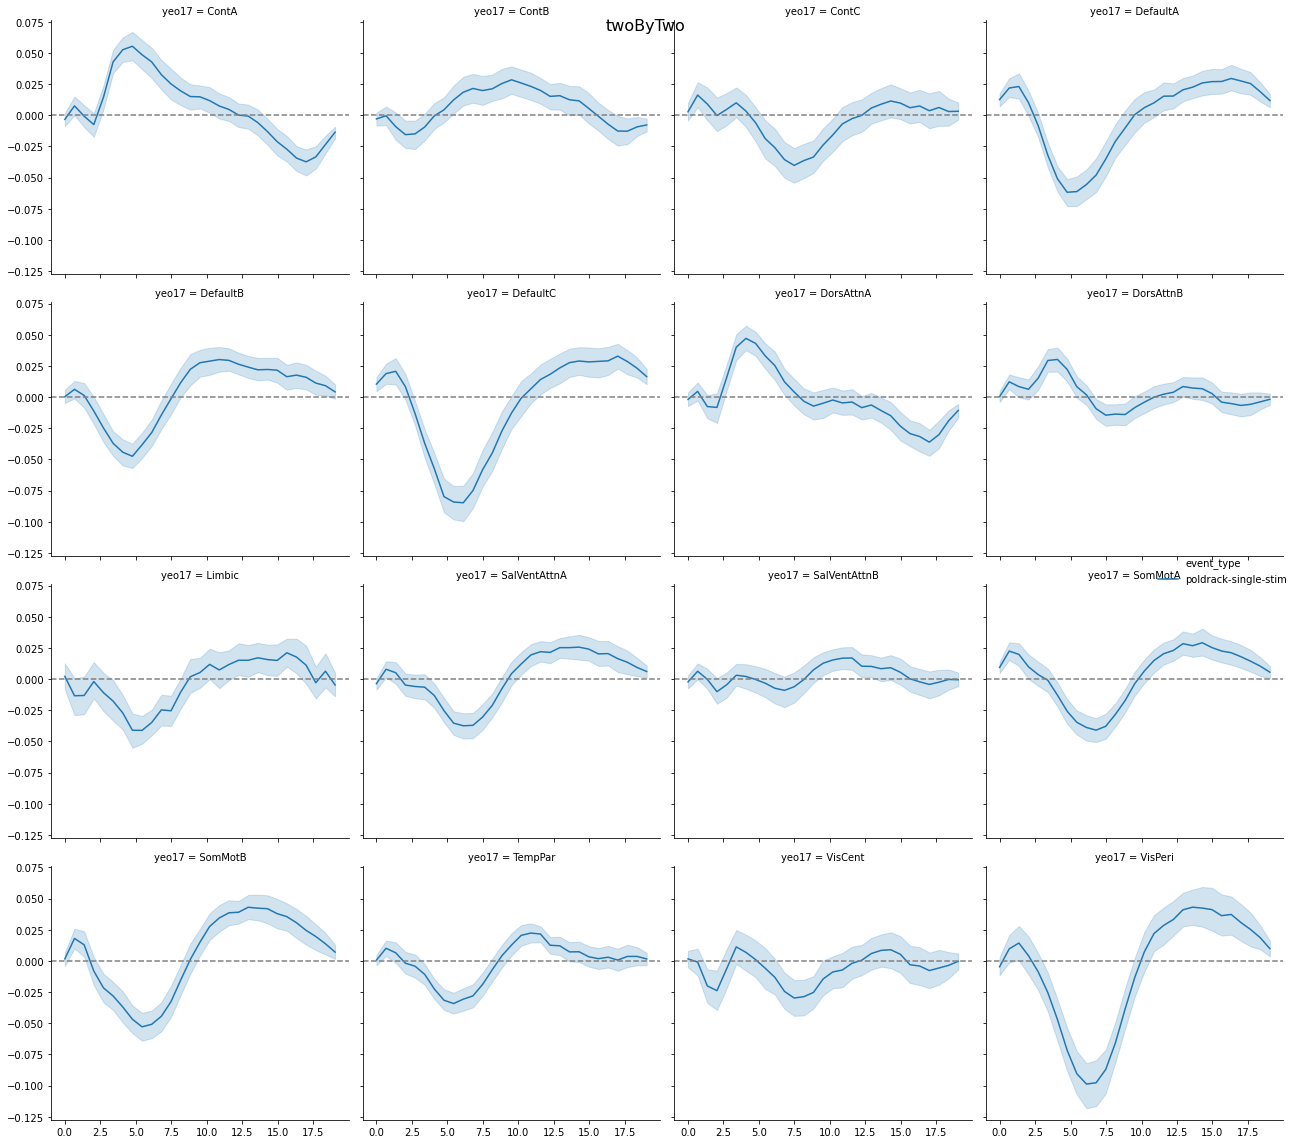

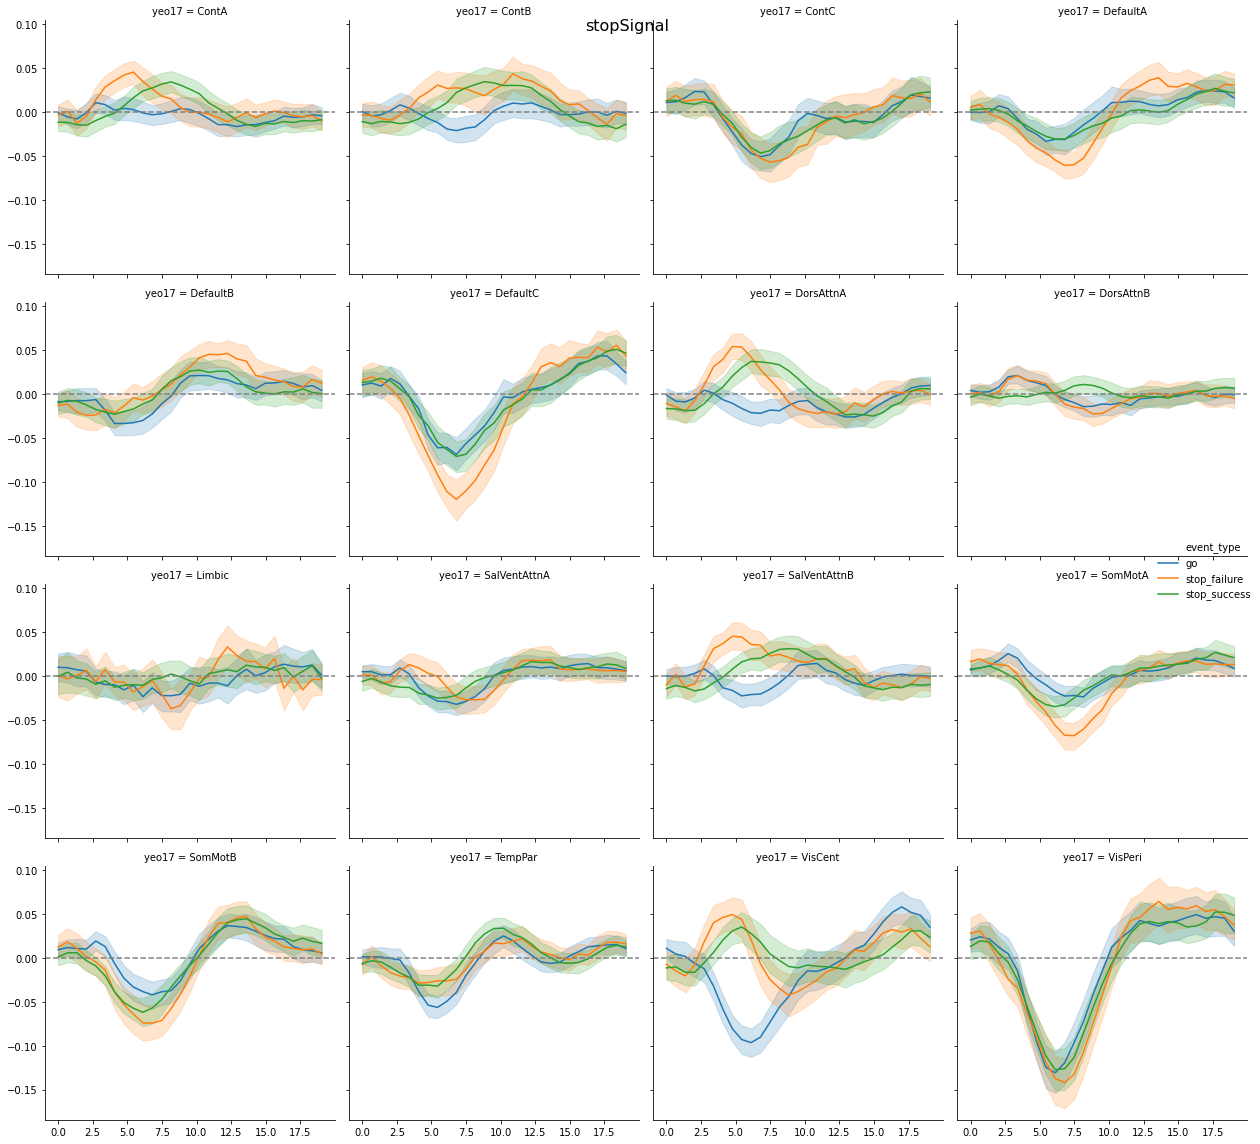

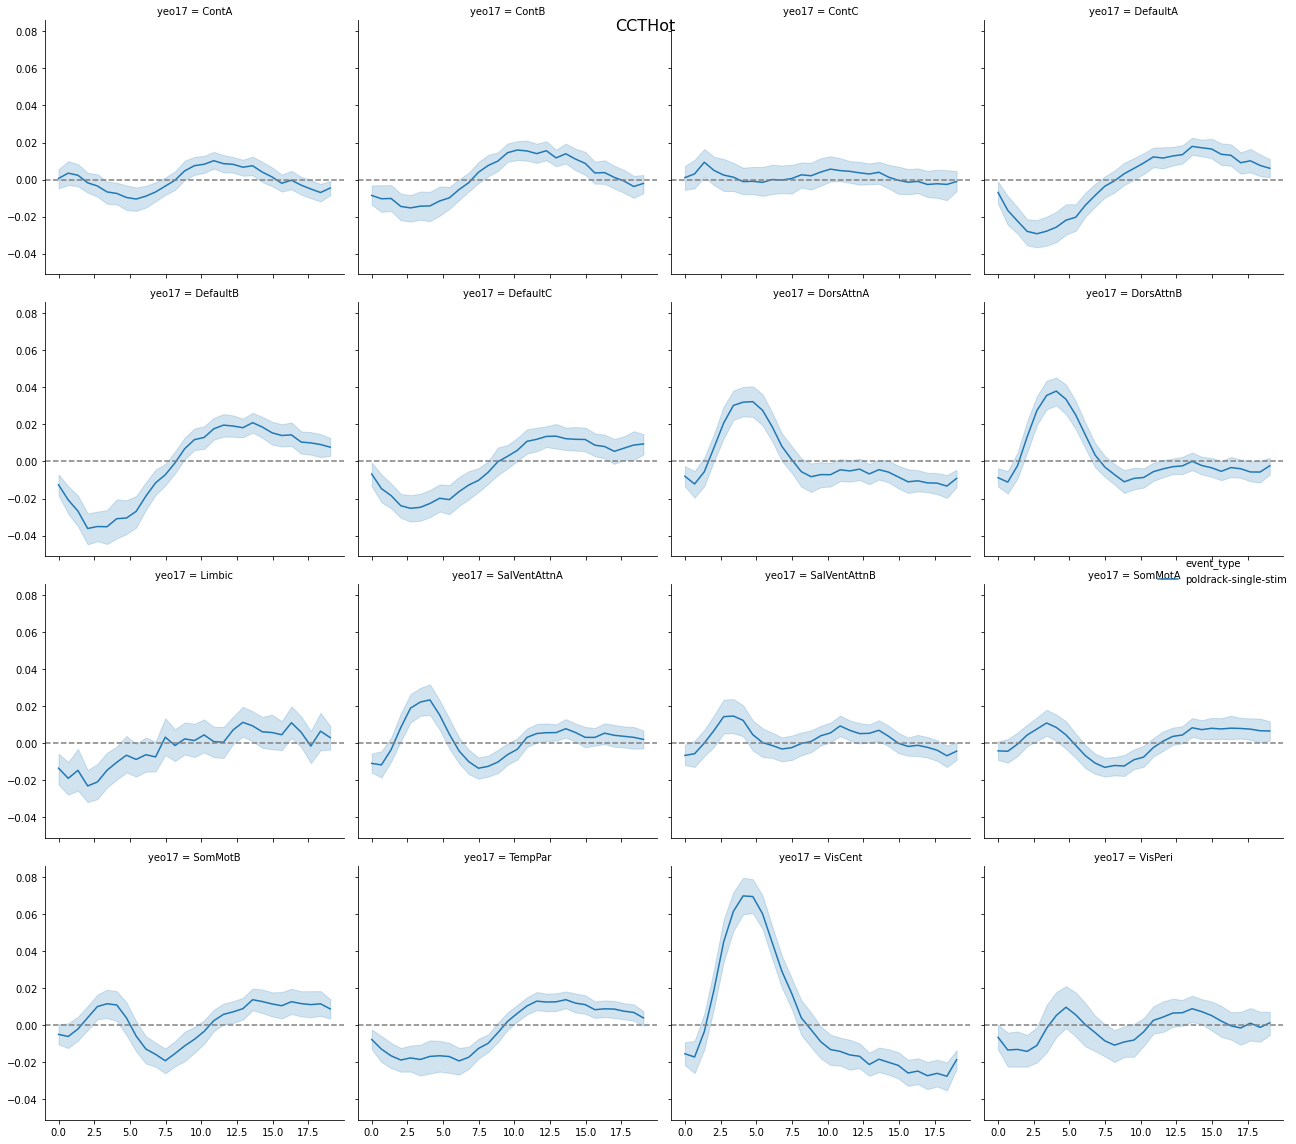

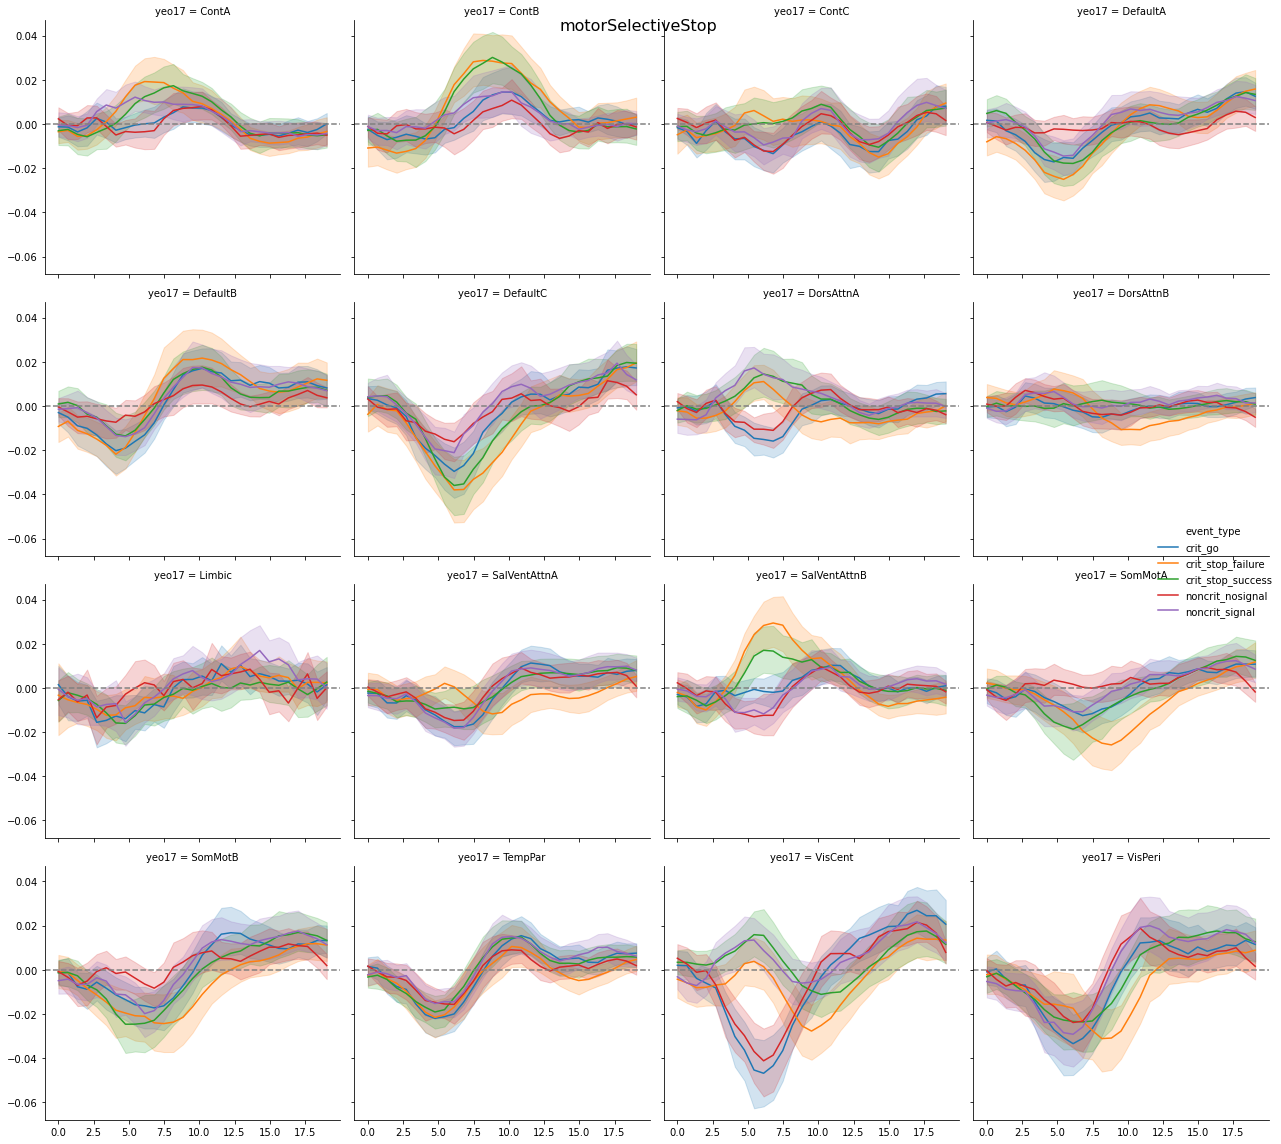

In [42]:
def make_network_plots(combined_data_long, task, spec_string, figure_dir):
    df = combined_data_long.query('task == "%s"' % task)
    p = sns.relplot(x='time', y='response', col="yeo17", 
                    col_wrap=4, height=4, hue='event_type', 
                    data=df, kind='line', n_boot=1000)
    p.add_legend()
    p.fig.suptitle(task, fontsize=16)
    p.map(plt.axhline, y=0, ls='--', c='gray')
    plt.savefig(os.path.join(figure_dir, '%s_%s_deconv.pdf' % (task, spec_string)))
    

for task in combined_data_long.task.unique():
    print('plotting', task)
    make_network_plots(yeo_network_summary, task, spec_string, figure_dir)
  